## 6.16 - Vectorized - NN Impl 

In this notebook, we'll show a vectorised implementation of a neural network.

Problem is a classification type problem, using softmax operator

## 1. Setup
### 1.1 Create Data

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

np.random.seed(seed=42)

X, y = make_circles(n_samples=200, factor=0.5, noise=0.15)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
labels = { 0: "dogs", 1: "cats"}
idx_class_0 = y_train == 0 
idx_class_1 = y_train == 1 

y_train_labels = np.zeros((y_train.size, 2)) 
y_train_labels[idx_class_1, 1] = 1
y_train_labels[idx_class_0, 0] = 1


y_test_labels = np.zeros((y_test.size, 2)) 
y_test_labels[y_test == 1 , 1] = 1
y_test_labels[y_test == 0 , 0] = 1
print("X_train:", X_train.shape)
print("y_train shape:", y_train_labels.shape)
print("X_test:", X_test.shape)
print("y_test shape:", y_test_labels.shape)

X_train: (150, 2)
y_train shape: (150, 2)
X_test: (50, 2)
y_test shape: (50, 2)


### 1.2 Plot Data

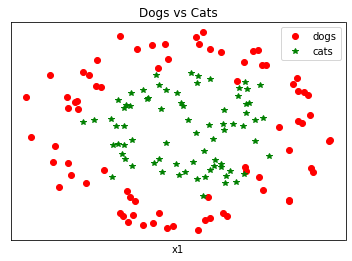

In [34]:
plt.plot(X_train[idx_class_0, 0], X_train[idx_class_0, 1], 'ro', label=labels[0])
plt.plot(X_train[idx_class_1, 0], X_train[idx_class_1, 1], 'g*', label=labels[1])
plt.gca().axes.get_yaxis().set_visible(False)

plt.title("Dogs vs Cats")
plt.xlabel("x1")
plt.ylabel("x2")
plt.xticks([])
plt.yticks([])
plt.legend()
plt.show()

## 2. Forward Pass

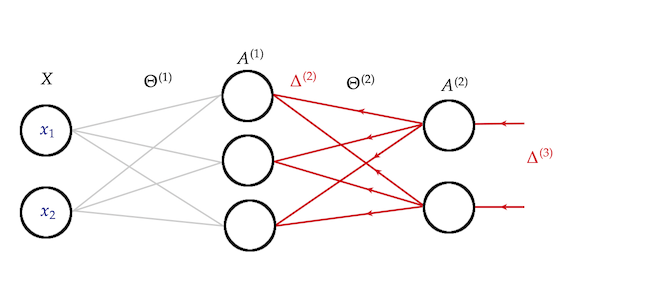

In [109]:
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)

def sigmoid(z):
    return 1. / (1. + np.exp(-z))

def output_layer_activation(A1, Theta_2, b2):
    return softmax((A1 @ Theta_2) + b2)

def hidden_layer_activation(X, Theta_1, b1):
    return sigmoid((X @ Theta_1) + b1)

def forward_pass(X, Theta_1, b1, Theta_2, b2):
    A1 = hidden_layer_activation(X, Theta_1, b1)
    A2 = output_layer_activation(A1, Theta_2, b2)
    return (A1, A2)


## 3. Calculate Loss

In [110]:
def cross_entropy_loss(Y_hat, Y):
    return - (Y * np.log(Y_hat)).sum() / Y.shape[0] 

def get_output_error(Y_hat, Y):
    return Y_hat - Y

def get_hidden_layer_error(A1, Theta_2, Delta_3):
    return np.multiply(np.multiply(A1,(1 - A1)), (Delta_3 @ Theta_2.T))


## 4. Calculate gradients using Backprop

In [111]:
def get_output_gradient(A1, Delta_3):
    return  A1.T @ Delta_3

def get_output_bias_gradient(Delta_3):
    return np.sum(Delta_3, axis=0, keepdims=True)

def get_hidden_gradient(X, Delta_2):
    return X.T @ Delta_2

def get_hidden_bias_gradient(Delta_2):
    return np.sum(Delta_2, axis=0, keepdims=True)

def calculate_gradients(X, Y, A1, A2, params):

    Theta_1, b1, Theta_2, b2 = params

    # Calculate Error 
    Delta_3 = get_output_error(A2, Y)
    Delta_2 = get_hidden_layer_error(A1, Theta_2, Delta_3)
    
    # Calculate Output Gradients
    JTheta_2 = get_output_gradient(A1, Delta_3)
    Jb2 = get_output_bias_gradient(Delta_3)
    
    # Calculate Hidden Layer Gradients
    JTheta_1 = get_hidden_gradient(X, Delta_2)
    
    Jb1 = get_hidden_bias_gradient(Delta_2)

    return [JTheta_1, Jb1, JTheta_2, Jb2]


## 5. Update network weights

In [112]:
def evaluate_validation_loss(X, y, params):
    Theta_1, b1, Theta_2, b2 = params
    _, yhat = forward_pass(X, Theta_1, b1, Theta_2, b2)
    return cross_entropy_loss(yhat, y)

def get_new_parameters(Js, params, learning_rate):    
    
    return [
    params[0] - (learning_rate * Js[0]),
    params[1] - (learning_rate * Js[1]),
    params[2] - (learning_rate * Js[2]),
    params[3] - (learning_rate * Js[3]) ]


## 6. Training

### 6.1 Initialize weights and biases

In [132]:
b1 = np.random.randn(1, 3) 
Theta_1 = np.random.randn(2, 3)
b2 = np.random.randn(1, 2)
Theta_2 = np.random.randn(3, 2)

training_loss = []
validation_loss = []

### 6.2 Train

In [138]:
learning_rate = 0.01
MAX_EPOCHS = 700

for i in range(0, MAX_EPOCHS):
    
    ## 1. Forward Pass
    A1, A2 = forward_pass(X_train, Theta_1, b1, Theta_2, b2)
    
    ## 2. Training Loss
    t_loss = cross_entropy_loss(A2, y_train_labels)
    training_loss.append(t_loss)
    
    # 3. Calculate Gradient
    params = (Theta_1, b1, Theta_2, b2)
    Js = calculate_gradients(X_train, y_train_labels, A1, A2, params)

    ## 4. Evaluate on validation set    
    v_loss = evaluate_validation_loss(X_test, y_test_labels, params)
    validation_loss.append(v_loss)

    ## 5. Update Weights
    Theta_1, b1, Theta_2, b2 = get_new_parameters(Js, params, learning_rate)


### 6.3 Print training loss

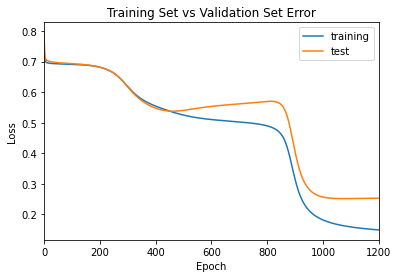

In [139]:
plt.plot(training_loss, label='training')
plt.plot(validation_loss, label='test')
plt.title("Training Set vs Validation Set Error")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xlim(0, len(training_loss))
plt.show()

### 6.4 Print Accuracy 

In [140]:
def accuracy(y, yhat):
    return np.mean((yhat == y))

def predict_labels(X, Theta_1, b1, Theta_2, b2):
    
    _, yhat = forward_pass(X, Theta_1, b1, Theta_2, b2)

    tmp = yhat >= 0.5
    predicted_labels = np.copy(yhat)
    predicted_labels[tmp] = 1
    predicted_labels[~tmp] = 0

    return predicted_labels


In [141]:
predicted_labels = predict_labels(X_train, Theta_1, b1, Theta_2, b2)
print(f"Accuracy (train) {accuracy(y_train_labels, predicted_labels):.3f}")

Accuracy (train) 0.953


In [142]:
predicted_labels_t = predict_labels(X_test, Theta_1, b1, Theta_2, b2)
print(f"Accuracy (test) {accuracy(y_test_labels, predicted_labels_t):.3f}")

Accuracy (test) 0.880
